# 0. 准备步骤，导包加载数据

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
batch_size = 256
epoch = 50
latent_space_dim = 2
hidden_space_dim = 400
img_size = 784

In [3]:
dataset = torchvision.datasets.MNIST(root='./data/',
                                     train=True,
                                     transform=torchvision.transforms.Compose([
                                         torchvision.transforms.ToTensor(),
                                     ]),
                                     download=True)

# 数据加载器
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [4]:
for data in data_loader:
    break

In [5]:
data[0].shape

torch.Size([256, 1, 28, 28])

# 1. 构建编码器

In [6]:
from torch import nn
import torch.nn.functional as F 
import torch
import numpy as np

In [7]:
class vaeEncoder(nn.Module):
    def __init__(self):
        super(vaeEncoder,self).__init__()
        self.conv_stages = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=8,out_channels=8,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
        
            nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
        
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
        )
        
        self.flatten = nn.Flatten()
        
        self.linear = nn.Sequential(
            nn.Linear(in_features=512,out_features=hidden_space_dim),
            nn.ReLU(),
        )
        
    def forward(self,inputs):
        outputs = self.conv_stages(inputs)
        
        outputs = self.flatten(outputs)
        
        outputs = self.linear(outputs)
        
        #outputs = self.max_pool(outputs)
        return outputs

# 2.构建解码器

In [8]:
class vaeDecoder(nn.Module):
    def __init__(self):
        super(vaeDecoder,self).__init__()
        
        self.linear = nn.Sequential(
            nn.Linear(in_features=latent_space_dim,out_features=512),
            nn.ReLU()
        )
        
        self.unflatten = nn.Unflatten(1, (32, 4, 4))
        
        self.t_conv_stage = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=16,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16,out_channels=8,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=8,out_channels=8,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8,out_channels=1,kernel_size=3,stride=2,padding=0,output_padding=1),
            nn.Sigmoid()
        )

        
    def forward(self,hidden_state):
        img = self.linear(hidden_state)
        img = self.unflatten(img)
        
        img = self.t_conv_stage(img)
        return img

# 3. 准备VAE的中间变量随机采样过程

In [9]:
class VAEModelv2(nn.Module):
    def __init__(self):
        super(VAEModelv2,self).__init__()
        # 有一个编码模型，用高级的ResNet或者ViT都行，前提是跑得动，我这里随便搞了一个
        # ResNet相关的，可以看Dalle的第一版的代码，那个CNN很高级
        # 编码器输入是[Batch,Channel,Width,Height]的多维图片；输出是[Batch,hidden_space_dim]的向量
        self.encoder = vaeEncoder() 

        # 解码器，用于把向量重建
        # 这里的输入是 [Batch,latent_space_dim]大小的向量，注意与编码器输出不一样，因为这里已经经过模拟了
        self.decoder = vaeDecoder()
        
        # 用于预测隐变量服从的多为高斯分布的方差与均值的线性层
        self.fitting_mean = nn.Linear(in_features=hidden_space_dim,out_features=latent_space_dim)
        self.fitting_log_var = nn.Linear(in_features=hidden_space_dim,out_features=latent_space_dim)
        
    def forward(self,imgs):
        x_hidden = self.encoder(imgs) # 先把图像转换成变量
        
        mean_pred = self.fitting_mean(x_hidden) # 然后预测隐变量的均值和方差
        log_var_pred = self.fitting_log_var(x_hidden)
        
        # sample from N(0,I)
        # re-parameter skill
        std = torch.exp(log_var_pred/2)
        eps = torch.randn_like(std)
        z = mean_pred + eps * std # 用于加一些噪声，并生成新的隐变量（也就是VAE的变化采样）
        #miu_norm = torch.randn_like(x_hidden)
        #z = torch.exp(log_var_pred) * miu_norm + mean_pred
        
        imgs_re = self.decoder(z)# 将带有变动的隐变量送入重建网络进行重建



        # 重建以后，与原始图像计算差距，下面都是计算差距的步骤
        # 有两种操作，第一种，不做标准化的话，就是我这里做的，这样会导致损失数值很大，当然可以收敛
        # 第二种操作就是下面写的，做一个标准化（把255转换到0.几）然后把标准化后的东西，与原始图片比较，
        # 这时候就不能用交叉熵计算，需要换成MSE或者L2，之前算MSE的时候没有收敛，不知道是不是哪里写错了。        
        
        # 因为做了标准化，所以重建的损失，不能用交叉熵算，需要用一个类似MSE的项计算
        # 但是不知道为什么这样做训练塌了，又换回去了
        # x_out = torch.sub(imgs_re,imgs) 
        # reconst_loss = 0.5 * torch.sum(torch.mean(x_out**2, 0)) + 0.5 * np.log(2*np.pi) * torch.prod(torch.tensor(x_out.shape[1:]))
        reconst_loss = F.binary_cross_entropy(imgs_re, imgs, size_average=False) # 因为没有标准化，所以是0-255，可以用交叉熵计算
        
        # 第二个损失是KL散度的损失，用于拟定，隐变量的分布服从于高斯分布
        # 至于里面为什么这么写，这是公式推出来的，别嘴硬
        kl_div = - 0.5 * torch.sum(1 + log_var_pred - mean_pred.pow(2) - log_var_pred.exp())
        
        return imgs_re,kl_div,reconst_loss

# 4. 训练过程

In [10]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision.utils import save_image

In [11]:
# 如果没有文件夹就创建一个文件夹
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [12]:
vae = VAEModelv2().cuda()
loss_log_list = []
kl_log = []
reconst_log = []

In [13]:
optimizer = torch.optim.Adam(
    vae.parameters(),
    lr=1e-4
)

In [14]:
for i in tqdm(range(epoch)):
    for j,(imgs,labels) in enumerate(data_loader):
        imgs = imgs.cuda()
        imgs_re,kl_div,reconst_loss = vae(imgs)
        loss = reconst_loss + kl_div
        #break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(loss)
        loss_log_list.append(loss.detach().cpu().numpy().tolist())
        kl_log.append(kl_div.detach().cpu().numpy().tolist())
        reconst_log.append(reconst_loss.detach().cpu().numpy().tolist())
        #break
        # 下面的记录可以看到，Loss数值很大，你们做的时候，需要注意平衡多项损失
        if j % 25 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(i+1, epoch, j+1, len(data_loader), reconst_loss.item(), kl_div.item()))
            
    with torch.no_grad():
        # 随机生成的图像
        z = torch.randn(batch_size, latent_space_dim).to(torch.device("cuda"))
        out = vae.decoder(z).view(-1, 1, 28, 28)
        save_image(out, 'vae_mnist/sampled-{}.png'.format(epoch+1))

        # 重构的图像
        out, _, _ = vae(imgs)
        x_concat = torch.cat([imgs.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, 'vae_mnist/reconst-{}.png'.format(epoch+1))
    #break


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]D:\Anaconda3\envs\bishe\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/50], Step [1/235], Reconst Loss: 127403.9844, KL Div: 0.3690
Epoch[1/50], Step [26/235], Reconst Loss: 126772.4844, KL Div: 0.0136
Epoch[1/50], Step [51/235], Reconst Loss: 125925.4219, KL Div: 0.7055
Epoch[1/50], Step [76/235], Reconst Loss: 124440.7656, KL Div: 17.8582
Epoch[1/50], Step [101/235], Reconst Loss: 115003.5469, KL Div: 2160.6289
Epoch[1/50], Step [126/235], Reconst Loss: 109845.0000, KL Div: 418.4866
Epoch[1/50], Step [151/235], Reconst Loss: 106314.0781, KL Div: 88.8487
Epoch[1/50], Step [176/235], Reconst Loss: 103925.4062, KL Div: 50.4662
Epoch[1/50], Step [201/235], Reconst Loss: 100716.0547, KL Div: 188.9106
Epoch[1/50], Step [226/235], Reconst Loss: 93439.0000, KL Div: 1147.7405



  2%|█▋                                                                                 | 1/50 [00:07<06:29,  7.95s/it]

Epoch[2/50], Step [1/235], Reconst Loss: 91154.2969, KL Div: 1697.3179
Epoch[2/50], Step [26/235], Reconst Loss: 81919.0234, KL Div: 2220.5732
Epoch[2/50], Step [51/235], Reconst Loss: 78561.3828, KL Div: 2424.2002
Epoch[2/50], Step [76/235], Reconst Loss: 74146.9453, KL Div: 2405.9006
Epoch[2/50], Step [101/235], Reconst Loss: 69739.7344, KL Div: 2400.7102
Epoch[2/50], Step [126/235], Reconst Loss: 67621.4688, KL Div: 2387.4360
Epoch[2/50], Step [151/235], Reconst Loss: 67346.1016, KL Div: 2033.2073
Epoch[2/50], Step [176/235], Reconst Loss: 65699.0234, KL Div: 2092.9988
Epoch[2/50], Step [201/235], Reconst Loss: 64974.4336, KL Div: 1871.3059
Epoch[2/50], Step [226/235], Reconst Loss: 64849.6445, KL Div: 1674.7532



  4%|███▎                                                                               | 2/50 [00:13<05:22,  6.72s/it]

Epoch[3/50], Step [1/235], Reconst Loss: 64544.5938, KL Div: 1747.1707
Epoch[3/50], Step [26/235], Reconst Loss: 63274.9375, KL Div: 1569.1506
Epoch[3/50], Step [51/235], Reconst Loss: 62885.3438, KL Div: 1577.6953
Epoch[3/50], Step [76/235], Reconst Loss: 63718.6875, KL Div: 1380.0549
Epoch[3/50], Step [101/235], Reconst Loss: 63469.9219, KL Div: 1451.5796
Epoch[3/50], Step [126/235], Reconst Loss: 61280.6094, KL Div: 1447.8645
Epoch[3/50], Step [151/235], Reconst Loss: 62711.8867, KL Div: 1264.0981
Epoch[3/50], Step [176/235], Reconst Loss: 59758.1094, KL Div: 1345.5469
Epoch[3/50], Step [201/235], Reconst Loss: 61148.2344, KL Div: 1215.6088
Epoch[3/50], Step [226/235], Reconst Loss: 61001.5586, KL Div: 1178.1948



  6%|████▉                                                                              | 3/50 [00:19<05:03,  6.45s/it]

Epoch[4/50], Step [1/235], Reconst Loss: 61697.8203, KL Div: 1171.7098
Epoch[4/50], Step [26/235], Reconst Loss: 59372.0547, KL Div: 1179.8701
Epoch[4/50], Step [51/235], Reconst Loss: 60335.9688, KL Div: 1140.1743
Epoch[4/50], Step [76/235], Reconst Loss: 59248.3516, KL Div: 1142.0717
Epoch[4/50], Step [101/235], Reconst Loss: 59930.3594, KL Div: 1144.3807
Epoch[4/50], Step [126/235], Reconst Loss: 58855.0547, KL Div: 1183.7341
Epoch[4/50], Step [151/235], Reconst Loss: 59490.8945, KL Div: 1102.1818
Epoch[4/50], Step [176/235], Reconst Loss: 57908.8594, KL Div: 1140.9388
Epoch[4/50], Step [201/235], Reconst Loss: 58501.0391, KL Div: 1068.5400
Epoch[4/50], Step [226/235], Reconst Loss: 57600.2383, KL Div: 1092.4221



  8%|██████▋                                                                            | 4/50 [00:25<04:47,  6.26s/it]

Epoch[5/50], Step [1/235], Reconst Loss: 58251.6094, KL Div: 1163.1133
Epoch[5/50], Step [26/235], Reconst Loss: 58975.6094, KL Div: 1108.2983
Epoch[5/50], Step [51/235], Reconst Loss: 57383.5195, KL Div: 1166.4668
Epoch[5/50], Step [76/235], Reconst Loss: 55597.8242, KL Div: 1226.4612
Epoch[5/50], Step [101/235], Reconst Loss: 55685.4883, KL Div: 1187.3796
Epoch[5/50], Step [126/235], Reconst Loss: 55956.8828, KL Div: 1223.1271
Epoch[5/50], Step [151/235], Reconst Loss: 55309.7344, KL Div: 1271.0239
Epoch[5/50], Step [176/235], Reconst Loss: 55269.1328, KL Div: 1232.5920
Epoch[5/50], Step [201/235], Reconst Loss: 54980.9766, KL Div: 1211.5901
Epoch[5/50], Step [226/235], Reconst Loss: 55184.2773, KL Div: 1198.9075



 10%|████████▎                                                                          | 5/50 [00:31<04:35,  6.13s/it]

Epoch[6/50], Step [1/235], Reconst Loss: 54875.1602, KL Div: 1216.1564
Epoch[6/50], Step [26/235], Reconst Loss: 54735.1953, KL Div: 1231.2795
Epoch[6/50], Step [51/235], Reconst Loss: 54991.5859, KL Div: 1192.1217
Epoch[6/50], Step [76/235], Reconst Loss: 55314.0625, KL Div: 1200.9397
Epoch[6/50], Step [101/235], Reconst Loss: 54691.9375, KL Div: 1225.6899
Epoch[6/50], Step [126/235], Reconst Loss: 54285.9062, KL Div: 1250.2485
Epoch[6/50], Step [151/235], Reconst Loss: 54425.9766, KL Div: 1210.1851
Epoch[6/50], Step [176/235], Reconst Loss: 54527.6250, KL Div: 1196.8528
Epoch[6/50], Step [201/235], Reconst Loss: 53574.1836, KL Div: 1264.5491
Epoch[6/50], Step [226/235], Reconst Loss: 54269.2344, KL Div: 1257.9562



 12%|█████████▉                                                                         | 6/50 [00:37<04:26,  6.05s/it]

Epoch[7/50], Step [1/235], Reconst Loss: 53937.5977, KL Div: 1246.2446
Epoch[7/50], Step [26/235], Reconst Loss: 53873.9844, KL Div: 1235.2034
Epoch[7/50], Step [51/235], Reconst Loss: 53653.7227, KL Div: 1237.6379
Epoch[7/50], Step [76/235], Reconst Loss: 54286.2852, KL Div: 1209.8276
Epoch[7/50], Step [101/235], Reconst Loss: 52217.7656, KL Div: 1276.3279
Epoch[7/50], Step [126/235], Reconst Loss: 53576.4219, KL Div: 1233.1301
Epoch[7/50], Step [151/235], Reconst Loss: 52803.7969, KL Div: 1226.5353
Epoch[7/50], Step [176/235], Reconst Loss: 54274.9102, KL Div: 1209.0559
Epoch[7/50], Step [201/235], Reconst Loss: 52657.3945, KL Div: 1228.5677
Epoch[7/50], Step [226/235], Reconst Loss: 53893.0742, KL Div: 1252.8511



 14%|███████████▌                                                                       | 7/50 [00:43<04:15,  5.94s/it]

Epoch[8/50], Step [1/235], Reconst Loss: 52619.2930, KL Div: 1259.4272
Epoch[8/50], Step [26/235], Reconst Loss: 53681.2344, KL Div: 1264.9371
Epoch[8/50], Step [51/235], Reconst Loss: 53080.8516, KL Div: 1246.3503
Epoch[8/50], Step [76/235], Reconst Loss: 50857.8984, KL Div: 1295.6158
Epoch[8/50], Step [101/235], Reconst Loss: 53959.7969, KL Div: 1225.1970
Epoch[8/50], Step [126/235], Reconst Loss: 52283.1406, KL Div: 1240.2581
Epoch[8/50], Step [151/235], Reconst Loss: 53176.8047, KL Div: 1234.5913
Epoch[8/50], Step [176/235], Reconst Loss: 53124.8984, KL Div: 1246.8120
Epoch[8/50], Step [201/235], Reconst Loss: 51428.0469, KL Div: 1259.3384
Epoch[8/50], Step [226/235], Reconst Loss: 53385.2422, KL Div: 1240.1465



 16%|█████████████▎                                                                     | 8/50 [00:49<04:05,  5.84s/it]

Epoch[9/50], Step [1/235], Reconst Loss: 52112.1328, KL Div: 1270.3115
Epoch[9/50], Step [26/235], Reconst Loss: 50968.2422, KL Div: 1237.7416
Epoch[9/50], Step [51/235], Reconst Loss: 52580.5234, KL Div: 1243.9243
Epoch[9/50], Step [76/235], Reconst Loss: 51709.1289, KL Div: 1236.0870
Epoch[9/50], Step [101/235], Reconst Loss: 52230.6328, KL Div: 1234.1244
Epoch[9/50], Step [126/235], Reconst Loss: 51242.7305, KL Div: 1254.9939
Epoch[9/50], Step [151/235], Reconst Loss: 52684.1641, KL Div: 1262.6248
Epoch[9/50], Step [176/235], Reconst Loss: 53382.6484, KL Div: 1223.6827
Epoch[9/50], Step [201/235], Reconst Loss: 51446.9922, KL Div: 1240.8989
Epoch[9/50], Step [226/235], Reconst Loss: 53603.9062, KL Div: 1234.0028



 18%|██████████████▉                                                                    | 9/50 [00:54<03:56,  5.77s/it]

Epoch[10/50], Step [1/235], Reconst Loss: 51953.7344, KL Div: 1262.8621
Epoch[10/50], Step [26/235], Reconst Loss: 52763.1562, KL Div: 1252.0747
Epoch[10/50], Step [51/235], Reconst Loss: 52998.9141, KL Div: 1217.3208
Epoch[10/50], Step [76/235], Reconst Loss: 52355.8359, KL Div: 1255.2886
Epoch[10/50], Step [101/235], Reconst Loss: 52123.1445, KL Div: 1230.7238
Epoch[10/50], Step [126/235], Reconst Loss: 51271.2812, KL Div: 1229.2222
Epoch[10/50], Step [151/235], Reconst Loss: 51792.6250, KL Div: 1257.5696
Epoch[10/50], Step [176/235], Reconst Loss: 52509.6875, KL Div: 1234.8962
Epoch[10/50], Step [201/235], Reconst Loss: 51915.1875, KL Div: 1235.1074
Epoch[10/50], Step [226/235], Reconst Loss: 50288.5156, KL Div: 1289.2107



 20%|████████████████▍                                                                 | 10/50 [01:00<03:48,  5.72s/it]

Epoch[11/50], Step [1/235], Reconst Loss: 49916.8672, KL Div: 1286.0160
Epoch[11/50], Step [26/235], Reconst Loss: 50340.2812, KL Div: 1260.0115
Epoch[11/50], Step [51/235], Reconst Loss: 52023.1250, KL Div: 1255.1952
Epoch[11/50], Step [76/235], Reconst Loss: 50854.6211, KL Div: 1277.1353
Epoch[11/50], Step [101/235], Reconst Loss: 51641.8281, KL Div: 1252.0944
Epoch[11/50], Step [126/235], Reconst Loss: 51148.2578, KL Div: 1250.0698
Epoch[11/50], Step [151/235], Reconst Loss: 51339.2891, KL Div: 1251.9103
Epoch[11/50], Step [176/235], Reconst Loss: 51511.3789, KL Div: 1257.4991
Epoch[11/50], Step [201/235], Reconst Loss: 51758.8672, KL Div: 1216.8584
Epoch[11/50], Step [226/235], Reconst Loss: 51742.8477, KL Div: 1231.7211



 22%|██████████████████                                                                | 11/50 [01:05<03:41,  5.68s/it]

Epoch[12/50], Step [1/235], Reconst Loss: 52455.7969, KL Div: 1223.4771
Epoch[12/50], Step [26/235], Reconst Loss: 51179.6641, KL Div: 1249.6160
Epoch[12/50], Step [51/235], Reconst Loss: 50880.9688, KL Div: 1253.6599
Epoch[12/50], Step [76/235], Reconst Loss: 50835.1367, KL Div: 1242.2358
Epoch[12/50], Step [101/235], Reconst Loss: 50635.6641, KL Div: 1267.5548
Epoch[12/50], Step [126/235], Reconst Loss: 51546.4844, KL Div: 1271.3196
Epoch[12/50], Step [151/235], Reconst Loss: 50995.7500, KL Div: 1244.3376
Epoch[12/50], Step [176/235], Reconst Loss: 51095.6562, KL Div: 1279.2223
Epoch[12/50], Step [201/235], Reconst Loss: 51115.4219, KL Div: 1263.2788
Epoch[12/50], Step [226/235], Reconst Loss: 51749.4375, KL Div: 1249.4092



 24%|███████████████████▋                                                              | 12/50 [01:11<03:34,  5.65s/it]

Epoch[13/50], Step [1/235], Reconst Loss: 49538.1094, KL Div: 1279.8650
Epoch[13/50], Step [26/235], Reconst Loss: 50672.2930, KL Div: 1252.4005
Epoch[13/50], Step [51/235], Reconst Loss: 50566.0781, KL Div: 1241.4976
Epoch[13/50], Step [76/235], Reconst Loss: 52742.1797, KL Div: 1209.2809
Epoch[13/50], Step [101/235], Reconst Loss: 52002.0547, KL Div: 1244.6915
Epoch[13/50], Step [126/235], Reconst Loss: 49297.2188, KL Div: 1267.5117
Epoch[13/50], Step [151/235], Reconst Loss: 50877.0391, KL Div: 1223.9973
Epoch[13/50], Step [176/235], Reconst Loss: 52314.3633, KL Div: 1247.5554
Epoch[13/50], Step [201/235], Reconst Loss: 50887.9531, KL Div: 1233.2736
Epoch[13/50], Step [226/235], Reconst Loss: 51582.8281, KL Div: 1264.5714



 26%|█████████████████████▎                                                            | 13/50 [01:17<03:28,  5.63s/it]

Epoch[14/50], Step [1/235], Reconst Loss: 50294.0898, KL Div: 1237.6073
Epoch[14/50], Step [26/235], Reconst Loss: 50673.3984, KL Div: 1258.1879
Epoch[14/50], Step [51/235], Reconst Loss: 50740.2656, KL Div: 1248.1746
Epoch[14/50], Step [76/235], Reconst Loss: 50368.8047, KL Div: 1258.9332
Epoch[14/50], Step [101/235], Reconst Loss: 51619.9609, KL Div: 1241.4667
Epoch[14/50], Step [126/235], Reconst Loss: 50820.9453, KL Div: 1280.0073
Epoch[14/50], Step [151/235], Reconst Loss: 50294.5547, KL Div: 1256.6431
Epoch[14/50], Step [176/235], Reconst Loss: 51385.1953, KL Div: 1238.7356
Epoch[14/50], Step [201/235], Reconst Loss: 50528.3906, KL Div: 1258.6597
Epoch[14/50], Step [226/235], Reconst Loss: 51514.2031, KL Div: 1239.6812



 28%|██████████████████████▉                                                           | 14/50 [01:22<03:22,  5.63s/it]

Epoch[15/50], Step [1/235], Reconst Loss: 51821.2031, KL Div: 1247.5833
Epoch[15/50], Step [26/235], Reconst Loss: 50224.3672, KL Div: 1267.1763
Epoch[15/50], Step [51/235], Reconst Loss: 49219.7617, KL Div: 1254.3033
Epoch[15/50], Step [76/235], Reconst Loss: 49867.7344, KL Div: 1233.4755
Epoch[15/50], Step [101/235], Reconst Loss: 50043.4531, KL Div: 1265.5343
Epoch[15/50], Step [126/235], Reconst Loss: 50969.3672, KL Div: 1253.2654
Epoch[15/50], Step [151/235], Reconst Loss: 48884.6758, KL Div: 1259.6252
Epoch[15/50], Step [176/235], Reconst Loss: 50054.7500, KL Div: 1257.7180
Epoch[15/50], Step [201/235], Reconst Loss: 51430.2266, KL Div: 1245.3320
Epoch[15/50], Step [226/235], Reconst Loss: 49404.0039, KL Div: 1258.3065



 30%|████████████████████████▌                                                         | 15/50 [01:28<03:16,  5.62s/it]

Epoch[16/50], Step [1/235], Reconst Loss: 50608.7695, KL Div: 1249.9473
Epoch[16/50], Step [26/235], Reconst Loss: 49811.7734, KL Div: 1289.6819
Epoch[16/50], Step [51/235], Reconst Loss: 49422.8438, KL Div: 1294.3065
Epoch[16/50], Step [76/235], Reconst Loss: 49950.1836, KL Div: 1208.5881
Epoch[16/50], Step [101/235], Reconst Loss: 50291.6914, KL Div: 1241.1575
Epoch[16/50], Step [126/235], Reconst Loss: 50427.1328, KL Div: 1263.3281
Epoch[16/50], Step [151/235], Reconst Loss: 49244.1641, KL Div: 1254.8674
Epoch[16/50], Step [176/235], Reconst Loss: 49874.5938, KL Div: 1260.6617
Epoch[16/50], Step [201/235], Reconst Loss: 49579.1562, KL Div: 1291.4438
Epoch[16/50], Step [226/235], Reconst Loss: 50000.3438, KL Div: 1251.8004



 32%|██████████████████████████▏                                                       | 16/50 [01:33<03:10,  5.61s/it]

Epoch[17/50], Step [1/235], Reconst Loss: 50550.5156, KL Div: 1242.8889
Epoch[17/50], Step [26/235], Reconst Loss: 49513.6328, KL Div: 1268.9945
Epoch[17/50], Step [51/235], Reconst Loss: 50091.3672, KL Div: 1274.3217
Epoch[17/50], Step [76/235], Reconst Loss: 51743.6484, KL Div: 1241.4778
Epoch[17/50], Step [101/235], Reconst Loss: 50040.3125, KL Div: 1243.1287
Epoch[17/50], Step [126/235], Reconst Loss: 50119.6523, KL Div: 1270.1785
Epoch[17/50], Step [151/235], Reconst Loss: 50659.1875, KL Div: 1241.8789
Epoch[17/50], Step [176/235], Reconst Loss: 50007.6523, KL Div: 1279.2058
Epoch[17/50], Step [201/235], Reconst Loss: 48921.8594, KL Div: 1286.6885
Epoch[17/50], Step [226/235], Reconst Loss: 50248.1719, KL Div: 1278.5060



 34%|███████████████████████████▉                                                      | 17/50 [01:39<03:05,  5.62s/it]

Epoch[18/50], Step [1/235], Reconst Loss: 50448.3203, KL Div: 1272.2224
Epoch[18/50], Step [26/235], Reconst Loss: 49649.5977, KL Div: 1276.4647
Epoch[18/50], Step [51/235], Reconst Loss: 49604.2891, KL Div: 1252.1938
Epoch[18/50], Step [76/235], Reconst Loss: 51788.2344, KL Div: 1259.4705
Epoch[18/50], Step [101/235], Reconst Loss: 49009.7891, KL Div: 1241.0469
Epoch[18/50], Step [126/235], Reconst Loss: 49663.7734, KL Div: 1248.4497
Epoch[18/50], Step [151/235], Reconst Loss: 50410.6406, KL Div: 1253.7915
Epoch[18/50], Step [176/235], Reconst Loss: 50082.9766, KL Div: 1251.7183
Epoch[18/50], Step [201/235], Reconst Loss: 49515.9883, KL Div: 1257.7722
Epoch[18/50], Step [226/235], Reconst Loss: 49569.6953, KL Div: 1283.5829



 36%|█████████████████████████████▌                                                    | 18/50 [01:45<02:59,  5.61s/it]

Epoch[19/50], Step [1/235], Reconst Loss: 49774.8086, KL Div: 1252.3389
Epoch[19/50], Step [26/235], Reconst Loss: 49696.8438, KL Div: 1273.0870
Epoch[19/50], Step [51/235], Reconst Loss: 48692.9570, KL Div: 1275.3193
Epoch[19/50], Step [76/235], Reconst Loss: 49920.3594, KL Div: 1247.9536
Epoch[19/50], Step [101/235], Reconst Loss: 49702.7109, KL Div: 1250.2351
Epoch[19/50], Step [126/235], Reconst Loss: 49064.7344, KL Div: 1236.4406
Epoch[19/50], Step [151/235], Reconst Loss: 48447.8906, KL Div: 1289.2725
Epoch[19/50], Step [176/235], Reconst Loss: 50303.2383, KL Div: 1246.3962
Epoch[19/50], Step [201/235], Reconst Loss: 49025.4727, KL Div: 1241.6969
Epoch[19/50], Step [226/235], Reconst Loss: 47350.2812, KL Div: 1284.6552



 38%|███████████████████████████████▏                                                  | 19/50 [01:50<02:54,  5.62s/it]

Epoch[20/50], Step [1/235], Reconst Loss: 49692.5859, KL Div: 1281.7139
Epoch[20/50], Step [26/235], Reconst Loss: 50024.6719, KL Div: 1253.6353
Epoch[20/50], Step [51/235], Reconst Loss: 48672.9492, KL Div: 1282.8962
Epoch[20/50], Step [76/235], Reconst Loss: 49546.4688, KL Div: 1230.1892
Epoch[20/50], Step [101/235], Reconst Loss: 49914.0781, KL Div: 1290.8217
Epoch[20/50], Step [126/235], Reconst Loss: 48402.4531, KL Div: 1244.6062
Epoch[20/50], Step [151/235], Reconst Loss: 49092.5664, KL Div: 1307.7604
Epoch[20/50], Step [176/235], Reconst Loss: 49331.2578, KL Div: 1282.8916
Epoch[20/50], Step [201/235], Reconst Loss: 48969.2656, KL Div: 1256.4827
Epoch[20/50], Step [226/235], Reconst Loss: 48714.4375, KL Div: 1260.1984



 40%|████████████████████████████████▊                                                 | 20/50 [01:56<02:48,  5.61s/it]

Epoch[21/50], Step [1/235], Reconst Loss: 48860.1172, KL Div: 1235.7673
Epoch[21/50], Step [26/235], Reconst Loss: 47556.2969, KL Div: 1283.4651
Epoch[21/50], Step [51/235], Reconst Loss: 50317.4375, KL Div: 1260.5845
Epoch[21/50], Step [76/235], Reconst Loss: 47723.6016, KL Div: 1272.2866
Epoch[21/50], Step [101/235], Reconst Loss: 47966.2148, KL Div: 1278.7856
Epoch[21/50], Step [126/235], Reconst Loss: 49512.4375, KL Div: 1272.3651
Epoch[21/50], Step [151/235], Reconst Loss: 47913.9141, KL Div: 1260.1938
Epoch[21/50], Step [176/235], Reconst Loss: 49232.0391, KL Div: 1231.4530
Epoch[21/50], Step [201/235], Reconst Loss: 49456.5859, KL Div: 1245.2222
Epoch[21/50], Step [226/235], Reconst Loss: 48313.6172, KL Div: 1289.1166



 42%|██████████████████████████████████▍                                               | 21/50 [02:01<02:42,  5.61s/it]

Epoch[22/50], Step [1/235], Reconst Loss: 47632.0703, KL Div: 1298.4056
Epoch[22/50], Step [26/235], Reconst Loss: 48716.6172, KL Div: 1247.2053
Epoch[22/50], Step [51/235], Reconst Loss: 48508.8438, KL Div: 1291.1261
Epoch[22/50], Step [76/235], Reconst Loss: 47373.7500, KL Div: 1311.1572
Epoch[22/50], Step [101/235], Reconst Loss: 46377.6016, KL Div: 1267.9417
Epoch[22/50], Step [126/235], Reconst Loss: 47914.4219, KL Div: 1296.9288
Epoch[22/50], Step [151/235], Reconst Loss: 46642.8828, KL Div: 1337.1599
Epoch[22/50], Step [176/235], Reconst Loss: 48895.9062, KL Div: 1242.3481
Epoch[22/50], Step [201/235], Reconst Loss: 48331.6016, KL Div: 1290.3795
Epoch[22/50], Step [226/235], Reconst Loss: 47720.4062, KL Div: 1289.3639



 44%|████████████████████████████████████                                              | 22/50 [02:07<02:36,  5.61s/it]

Epoch[23/50], Step [1/235], Reconst Loss: 48008.3086, KL Div: 1307.7333
Epoch[23/50], Step [26/235], Reconst Loss: 47248.2109, KL Div: 1298.3062
Epoch[23/50], Step [51/235], Reconst Loss: 48661.6797, KL Div: 1249.4717
Epoch[23/50], Step [76/235], Reconst Loss: 48389.1797, KL Div: 1301.0490
Epoch[23/50], Step [101/235], Reconst Loss: 47815.5078, KL Div: 1273.2844
Epoch[23/50], Step [126/235], Reconst Loss: 49233.3125, KL Div: 1302.4973
Epoch[23/50], Step [151/235], Reconst Loss: 48307.3320, KL Div: 1311.6542
Epoch[23/50], Step [176/235], Reconst Loss: 49725.7578, KL Div: 1270.9612
Epoch[23/50], Step [201/235], Reconst Loss: 49265.7266, KL Div: 1286.5776
Epoch[23/50], Step [226/235], Reconst Loss: 48861.0469, KL Div: 1310.1006



 46%|█████████████████████████████████████▋                                            | 23/50 [02:13<02:31,  5.61s/it]

Epoch[24/50], Step [1/235], Reconst Loss: 46447.8984, KL Div: 1291.0098
Epoch[24/50], Step [26/235], Reconst Loss: 46883.6094, KL Div: 1313.3821
Epoch[24/50], Step [51/235], Reconst Loss: 47589.3047, KL Div: 1297.5492
Epoch[24/50], Step [76/235], Reconst Loss: 48042.7930, KL Div: 1311.2356
Epoch[24/50], Step [101/235], Reconst Loss: 46755.5273, KL Div: 1323.9296
Epoch[24/50], Step [126/235], Reconst Loss: 46705.5625, KL Div: 1304.7595
Epoch[24/50], Step [151/235], Reconst Loss: 48560.9922, KL Div: 1334.1787
Epoch[24/50], Step [176/235], Reconst Loss: 46480.8203, KL Div: 1323.5857
Epoch[24/50], Step [201/235], Reconst Loss: 48782.2969, KL Div: 1289.7417
Epoch[24/50], Step [226/235], Reconst Loss: 47907.3867, KL Div: 1315.2610



 48%|███████████████████████████████████████▎                                          | 24/50 [02:18<02:26,  5.62s/it]

Epoch[25/50], Step [1/235], Reconst Loss: 48636.2500, KL Div: 1284.8870
Epoch[25/50], Step [26/235], Reconst Loss: 47104.5039, KL Div: 1307.0953
Epoch[25/50], Step [51/235], Reconst Loss: 46222.1016, KL Div: 1299.5935
Epoch[25/50], Step [76/235], Reconst Loss: 48186.8945, KL Div: 1305.3284
Epoch[25/50], Step [101/235], Reconst Loss: 48097.9453, KL Div: 1284.0825
Epoch[25/50], Step [126/235], Reconst Loss: 48246.0039, KL Div: 1269.7789
Epoch[25/50], Step [151/235], Reconst Loss: 48597.1016, KL Div: 1316.7090
Epoch[25/50], Step [176/235], Reconst Loss: 46829.0117, KL Div: 1355.8425
Epoch[25/50], Step [201/235], Reconst Loss: 46992.0234, KL Div: 1296.7555
Epoch[25/50], Step [226/235], Reconst Loss: 48311.5430, KL Div: 1333.5952



 50%|█████████████████████████████████████████                                         | 25/50 [02:24<02:20,  5.63s/it]

Epoch[26/50], Step [1/235], Reconst Loss: 47289.8477, KL Div: 1309.8729
Epoch[26/50], Step [26/235], Reconst Loss: 47030.3516, KL Div: 1325.5176
Epoch[26/50], Step [51/235], Reconst Loss: 47259.6914, KL Div: 1287.3884
Epoch[26/50], Step [76/235], Reconst Loss: 45354.6406, KL Div: 1357.8701
Epoch[26/50], Step [101/235], Reconst Loss: 46464.6289, KL Div: 1334.6395
Epoch[26/50], Step [126/235], Reconst Loss: 46639.7188, KL Div: 1291.1816
Epoch[26/50], Step [151/235], Reconst Loss: 46931.2109, KL Div: 1322.9977
Epoch[26/50], Step [176/235], Reconst Loss: 47811.4375, KL Div: 1301.2863
Epoch[26/50], Step [201/235], Reconst Loss: 48057.3672, KL Div: 1287.1406
Epoch[26/50], Step [226/235], Reconst Loss: 45593.1250, KL Div: 1356.0000



 52%|██████████████████████████████████████████▋                                       | 26/50 [02:30<02:15,  5.63s/it]

Epoch[27/50], Step [1/235], Reconst Loss: 46377.1328, KL Div: 1346.8428
Epoch[27/50], Step [26/235], Reconst Loss: 46645.7344, KL Div: 1347.8499
Epoch[27/50], Step [51/235], Reconst Loss: 47333.3906, KL Div: 1319.6731
Epoch[27/50], Step [76/235], Reconst Loss: 47035.1016, KL Div: 1329.0154
Epoch[27/50], Step [101/235], Reconst Loss: 44968.3555, KL Div: 1323.5786
Epoch[27/50], Step [126/235], Reconst Loss: 47122.8750, KL Div: 1337.4991
Epoch[27/50], Step [151/235], Reconst Loss: 47317.6172, KL Div: 1325.3958
Epoch[27/50], Step [176/235], Reconst Loss: 45463.9453, KL Div: 1307.5630
Epoch[27/50], Step [201/235], Reconst Loss: 46549.0781, KL Div: 1307.7043
Epoch[27/50], Step [226/235], Reconst Loss: 46196.3359, KL Div: 1319.3052



 54%|████████████████████████████████████████████▎                                     | 27/50 [02:35<02:09,  5.63s/it]

Epoch[28/50], Step [1/235], Reconst Loss: 47875.3047, KL Div: 1306.3174
Epoch[28/50], Step [26/235], Reconst Loss: 47164.1250, KL Div: 1332.0438
Epoch[28/50], Step [51/235], Reconst Loss: 45641.7266, KL Div: 1281.3579
Epoch[28/50], Step [76/235], Reconst Loss: 47198.1289, KL Div: 1333.8225
Epoch[28/50], Step [101/235], Reconst Loss: 47628.1797, KL Div: 1328.2701
Epoch[28/50], Step [126/235], Reconst Loss: 46941.1914, KL Div: 1327.2375
Epoch[28/50], Step [151/235], Reconst Loss: 46521.0391, KL Div: 1319.5823
Epoch[28/50], Step [176/235], Reconst Loss: 45666.1172, KL Div: 1355.3052
Epoch[28/50], Step [201/235], Reconst Loss: 46532.2422, KL Div: 1320.3488
Epoch[28/50], Step [226/235], Reconst Loss: 46625.3203, KL Div: 1322.6914



 56%|█████████████████████████████████████████████▉                                    | 28/50 [02:41<02:03,  5.62s/it]

Epoch[29/50], Step [1/235], Reconst Loss: 46987.4297, KL Div: 1319.7657
Epoch[29/50], Step [26/235], Reconst Loss: 47006.2266, KL Div: 1314.8247
Epoch[29/50], Step [51/235], Reconst Loss: 47399.1562, KL Div: 1327.6754
Epoch[29/50], Step [76/235], Reconst Loss: 46342.0391, KL Div: 1313.4614
Epoch[29/50], Step [101/235], Reconst Loss: 46327.3047, KL Div: 1376.4082
Epoch[29/50], Step [126/235], Reconst Loss: 47837.7891, KL Div: 1298.5447
Epoch[29/50], Step [151/235], Reconst Loss: 45222.1602, KL Div: 1342.5089
Epoch[29/50], Step [176/235], Reconst Loss: 44739.1914, KL Div: 1388.0336
Epoch[29/50], Step [201/235], Reconst Loss: 46829.0156, KL Div: 1328.3939
Epoch[29/50], Step [226/235], Reconst Loss: 47420.2734, KL Div: 1331.2715



 58%|███████████████████████████████████████████████▌                                  | 29/50 [02:46<01:58,  5.62s/it]

Epoch[30/50], Step [1/235], Reconst Loss: 44905.7070, KL Div: 1356.6641
Epoch[30/50], Step [26/235], Reconst Loss: 44650.7344, KL Div: 1356.2576
Epoch[30/50], Step [51/235], Reconst Loss: 45440.0625, KL Div: 1382.5963
Epoch[30/50], Step [76/235], Reconst Loss: 45262.8516, KL Div: 1337.7916
Epoch[30/50], Step [101/235], Reconst Loss: 46269.1133, KL Div: 1357.8931
Epoch[30/50], Step [126/235], Reconst Loss: 47981.1406, KL Div: 1334.5900
Epoch[30/50], Step [151/235], Reconst Loss: 46225.5156, KL Div: 1340.7139
Epoch[30/50], Step [176/235], Reconst Loss: 46923.0312, KL Div: 1357.6636
Epoch[30/50], Step [201/235], Reconst Loss: 45903.1758, KL Div: 1325.8866
Epoch[30/50], Step [226/235], Reconst Loss: 44569.5664, KL Div: 1368.8657



 60%|█████████████████████████████████████████████████▏                                | 30/50 [02:52<01:52,  5.62s/it]

Epoch[31/50], Step [1/235], Reconst Loss: 47256.1953, KL Div: 1339.8043
Epoch[31/50], Step [26/235], Reconst Loss: 47099.5430, KL Div: 1321.1881
Epoch[31/50], Step [51/235], Reconst Loss: 46973.4375, KL Div: 1327.2678
Epoch[31/50], Step [76/235], Reconst Loss: 45514.6250, KL Div: 1357.2009
Epoch[31/50], Step [101/235], Reconst Loss: 45922.6289, KL Div: 1361.4779
Epoch[31/50], Step [126/235], Reconst Loss: 45313.0508, KL Div: 1324.0542
Epoch[31/50], Step [151/235], Reconst Loss: 45430.4375, KL Div: 1334.7866
Epoch[31/50], Step [176/235], Reconst Loss: 45369.4922, KL Div: 1348.6743
Epoch[31/50], Step [201/235], Reconst Loss: 46361.9609, KL Div: 1375.2974
Epoch[31/50], Step [226/235], Reconst Loss: 46715.8984, KL Div: 1351.1277



 62%|██████████████████████████████████████████████████▊                               | 31/50 [02:58<01:46,  5.62s/it]

Epoch[32/50], Step [1/235], Reconst Loss: 46891.6953, KL Div: 1350.7864
Epoch[32/50], Step [26/235], Reconst Loss: 45945.6406, KL Div: 1321.7646
Epoch[32/50], Step [51/235], Reconst Loss: 45849.2383, KL Div: 1349.2720
Epoch[32/50], Step [76/235], Reconst Loss: 46821.3281, KL Div: 1327.0717
Epoch[32/50], Step [101/235], Reconst Loss: 46461.9219, KL Div: 1334.5127
Epoch[32/50], Step [126/235], Reconst Loss: 46562.0156, KL Div: 1351.4849
Epoch[32/50], Step [151/235], Reconst Loss: 45213.0000, KL Div: 1358.7969
Epoch[32/50], Step [176/235], Reconst Loss: 45931.6914, KL Div: 1373.8469
Epoch[32/50], Step [201/235], Reconst Loss: 44990.8203, KL Div: 1362.0266
Epoch[32/50], Step [226/235], Reconst Loss: 46109.7695, KL Div: 1353.9214



 64%|████████████████████████████████████████████████████▍                             | 32/50 [03:03<01:41,  5.62s/it]

Epoch[33/50], Step [1/235], Reconst Loss: 47042.0547, KL Div: 1331.8135
Epoch[33/50], Step [26/235], Reconst Loss: 45364.9375, KL Div: 1370.6223
Epoch[33/50], Step [51/235], Reconst Loss: 46352.7656, KL Div: 1362.6497
Epoch[33/50], Step [76/235], Reconst Loss: 46653.7031, KL Div: 1342.8774
Epoch[33/50], Step [101/235], Reconst Loss: 46081.5234, KL Div: 1326.5696
Epoch[33/50], Step [126/235], Reconst Loss: 46783.2109, KL Div: 1346.2471
Epoch[33/50], Step [151/235], Reconst Loss: 45350.7734, KL Div: 1359.0654
Epoch[33/50], Step [176/235], Reconst Loss: 44235.1953, KL Div: 1388.0273
Epoch[33/50], Step [201/235], Reconst Loss: 45114.1562, KL Div: 1346.4331
Epoch[33/50], Step [226/235], Reconst Loss: 45747.1680, KL Div: 1392.5718



 66%|██████████████████████████████████████████████████████                            | 33/50 [03:09<01:35,  5.62s/it]

Epoch[34/50], Step [1/235], Reconst Loss: 44827.5156, KL Div: 1365.9435
Epoch[34/50], Step [26/235], Reconst Loss: 46053.6602, KL Div: 1347.2983
Epoch[34/50], Step [51/235], Reconst Loss: 46500.6953, KL Div: 1355.1660
Epoch[34/50], Step [76/235], Reconst Loss: 45739.0898, KL Div: 1345.9164
Epoch[34/50], Step [101/235], Reconst Loss: 44618.7969, KL Div: 1394.7083
Epoch[34/50], Step [126/235], Reconst Loss: 46819.1406, KL Div: 1340.1324
Epoch[34/50], Step [151/235], Reconst Loss: 44020.2422, KL Div: 1420.7393
Epoch[34/50], Step [176/235], Reconst Loss: 44604.3203, KL Div: 1365.6293
Epoch[34/50], Step [201/235], Reconst Loss: 45202.6914, KL Div: 1401.2920
Epoch[34/50], Step [226/235], Reconst Loss: 44598.4375, KL Div: 1377.0198



 68%|███████████████████████████████████████████████████████▊                          | 34/50 [03:14<01:29,  5.62s/it]

Epoch[35/50], Step [1/235], Reconst Loss: 44640.0156, KL Div: 1393.3365
Epoch[35/50], Step [26/235], Reconst Loss: 44192.4297, KL Div: 1392.6235
Epoch[35/50], Step [51/235], Reconst Loss: 46114.7227, KL Div: 1341.5743
Epoch[35/50], Step [76/235], Reconst Loss: 44826.0430, KL Div: 1373.3245
Epoch[35/50], Step [101/235], Reconst Loss: 45544.9297, KL Div: 1388.6572
Epoch[35/50], Step [126/235], Reconst Loss: 44151.4492, KL Div: 1378.5251
Epoch[35/50], Step [151/235], Reconst Loss: 45553.0078, KL Div: 1345.9578
Epoch[35/50], Step [176/235], Reconst Loss: 43111.5273, KL Div: 1380.3040
Epoch[35/50], Step [201/235], Reconst Loss: 44582.3984, KL Div: 1368.5128
Epoch[35/50], Step [226/235], Reconst Loss: 45859.6445, KL Div: 1404.1135



 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [03:20<01:24,  5.61s/it]

Epoch[36/50], Step [1/235], Reconst Loss: 45687.5938, KL Div: 1393.7711
Epoch[36/50], Step [26/235], Reconst Loss: 45902.2188, KL Div: 1341.9296
Epoch[36/50], Step [51/235], Reconst Loss: 44645.6562, KL Div: 1407.5872
Epoch[36/50], Step [76/235], Reconst Loss: 44351.0820, KL Div: 1370.3474
Epoch[36/50], Step [101/235], Reconst Loss: 44934.8438, KL Div: 1369.5818
Epoch[36/50], Step [126/235], Reconst Loss: 44727.8047, KL Div: 1395.4924
Epoch[36/50], Step [151/235], Reconst Loss: 46201.0469, KL Div: 1348.9421
Epoch[36/50], Step [176/235], Reconst Loss: 44233.5391, KL Div: 1367.3887
Epoch[36/50], Step [201/235], Reconst Loss: 44567.4961, KL Div: 1386.6075
Epoch[36/50], Step [226/235], Reconst Loss: 45713.8750, KL Div: 1372.4835



 72%|███████████████████████████████████████████████████████████                       | 36/50 [03:26<01:18,  5.61s/it]

Epoch[37/50], Step [1/235], Reconst Loss: 44608.8281, KL Div: 1387.9314
Epoch[37/50], Step [26/235], Reconst Loss: 44336.7617, KL Div: 1415.3320
Epoch[37/50], Step [51/235], Reconst Loss: 45017.6523, KL Div: 1357.5452
Epoch[37/50], Step [76/235], Reconst Loss: 44765.1953, KL Div: 1355.5894
Epoch[37/50], Step [101/235], Reconst Loss: 45558.1445, KL Div: 1395.4036
Epoch[37/50], Step [126/235], Reconst Loss: 44432.6172, KL Div: 1391.1455
Epoch[37/50], Step [151/235], Reconst Loss: 44741.3984, KL Div: 1359.6909
Epoch[37/50], Step [176/235], Reconst Loss: 44931.6523, KL Div: 1384.9435
Epoch[37/50], Step [201/235], Reconst Loss: 43594.1484, KL Div: 1422.4337
Epoch[37/50], Step [226/235], Reconst Loss: 45193.8867, KL Div: 1380.0118



 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [03:31<01:12,  5.61s/it]

Epoch[38/50], Step [1/235], Reconst Loss: 44718.2695, KL Div: 1383.5277
Epoch[38/50], Step [26/235], Reconst Loss: 43730.8125, KL Div: 1411.6715
Epoch[38/50], Step [51/235], Reconst Loss: 44371.6172, KL Div: 1390.8477
Epoch[38/50], Step [76/235], Reconst Loss: 43520.9609, KL Div: 1401.8726
Epoch[38/50], Step [101/235], Reconst Loss: 45905.8281, KL Div: 1380.0529
Epoch[38/50], Step [126/235], Reconst Loss: 43934.8516, KL Div: 1381.4138
Epoch[38/50], Step [151/235], Reconst Loss: 44621.2266, KL Div: 1380.2021
Epoch[38/50], Step [176/235], Reconst Loss: 42507.5000, KL Div: 1399.5383
Epoch[38/50], Step [201/235], Reconst Loss: 43566.8594, KL Div: 1406.4795
Epoch[38/50], Step [226/235], Reconst Loss: 44925.3125, KL Div: 1384.7229



 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [03:37<01:07,  5.60s/it]

Epoch[39/50], Step [1/235], Reconst Loss: 44749.5859, KL Div: 1369.1992
Epoch[39/50], Step [26/235], Reconst Loss: 44119.4688, KL Div: 1431.9834
Epoch[39/50], Step [51/235], Reconst Loss: 43187.9766, KL Div: 1391.7461
Epoch[39/50], Step [76/235], Reconst Loss: 45333.4453, KL Div: 1417.6815
Epoch[39/50], Step [101/235], Reconst Loss: 45637.6602, KL Div: 1414.8777
Epoch[39/50], Step [126/235], Reconst Loss: 43311.9414, KL Div: 1400.7856
Epoch[39/50], Step [151/235], Reconst Loss: 44615.8828, KL Div: 1378.8542
Epoch[39/50], Step [176/235], Reconst Loss: 42860.2148, KL Div: 1433.4055
Epoch[39/50], Step [201/235], Reconst Loss: 45267.5195, KL Div: 1378.6277
Epoch[39/50], Step [226/235], Reconst Loss: 43346.4844, KL Div: 1427.9209



 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [03:43<01:02,  5.65s/it]

Epoch[40/50], Step [1/235], Reconst Loss: 45337.5742, KL Div: 1409.5812
Epoch[40/50], Step [26/235], Reconst Loss: 43042.7422, KL Div: 1414.8232
Epoch[40/50], Step [51/235], Reconst Loss: 44235.7930, KL Div: 1398.6415
Epoch[40/50], Step [76/235], Reconst Loss: 45155.6367, KL Div: 1401.9092
Epoch[40/50], Step [101/235], Reconst Loss: 44095.2930, KL Div: 1404.5293
Epoch[40/50], Step [126/235], Reconst Loss: 43696.0898, KL Div: 1406.8269
Epoch[40/50], Step [151/235], Reconst Loss: 43386.0859, KL Div: 1431.6023
Epoch[40/50], Step [176/235], Reconst Loss: 43345.8438, KL Div: 1408.1819
Epoch[40/50], Step [201/235], Reconst Loss: 43091.3594, KL Div: 1422.6918
Epoch[40/50], Step [226/235], Reconst Loss: 43133.3594, KL Div: 1400.3979



 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [03:48<00:56,  5.65s/it]

Epoch[41/50], Step [1/235], Reconst Loss: 42610.8164, KL Div: 1479.1560
Epoch[41/50], Step [26/235], Reconst Loss: 43280.2891, KL Div: 1401.1390
Epoch[41/50], Step [51/235], Reconst Loss: 44557.8789, KL Div: 1392.6504
Epoch[41/50], Step [76/235], Reconst Loss: 43142.1836, KL Div: 1406.4971
Epoch[41/50], Step [101/235], Reconst Loss: 44005.0078, KL Div: 1406.7351
Epoch[41/50], Step [126/235], Reconst Loss: 43205.9180, KL Div: 1403.1595
Epoch[41/50], Step [151/235], Reconst Loss: 43152.9023, KL Div: 1417.1682
Epoch[41/50], Step [176/235], Reconst Loss: 43549.6797, KL Div: 1455.6555
Epoch[41/50], Step [201/235], Reconst Loss: 43295.4453, KL Div: 1415.0713
Epoch[41/50], Step [226/235], Reconst Loss: 44927.2812, KL Div: 1385.2031



 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [03:54<00:50,  5.65s/it]

Epoch[42/50], Step [1/235], Reconst Loss: 43560.7539, KL Div: 1397.4314
Epoch[42/50], Step [26/235], Reconst Loss: 43211.1719, KL Div: 1401.2053
Epoch[42/50], Step [51/235], Reconst Loss: 42151.5547, KL Div: 1420.1064
Epoch[42/50], Step [76/235], Reconst Loss: 43889.4922, KL Div: 1396.9032
Epoch[42/50], Step [101/235], Reconst Loss: 43186.8555, KL Div: 1407.2212
Epoch[42/50], Step [126/235], Reconst Loss: 43356.0859, KL Div: 1448.4894
Epoch[42/50], Step [151/235], Reconst Loss: 44526.9414, KL Div: 1424.3197
Epoch[42/50], Step [176/235], Reconst Loss: 43806.2188, KL Div: 1403.2692
Epoch[42/50], Step [201/235], Reconst Loss: 44071.1797, KL Div: 1424.4689
Epoch[42/50], Step [226/235], Reconst Loss: 43447.9609, KL Div: 1389.7134



 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [04:00<00:45,  5.65s/it]

Epoch[43/50], Step [1/235], Reconst Loss: 43623.0625, KL Div: 1427.5876
Epoch[43/50], Step [26/235], Reconst Loss: 43589.8906, KL Div: 1433.3232
Epoch[43/50], Step [51/235], Reconst Loss: 43552.4531, KL Div: 1440.7273
Epoch[43/50], Step [76/235], Reconst Loss: 43588.7227, KL Div: 1435.4055
Epoch[43/50], Step [101/235], Reconst Loss: 42575.8711, KL Div: 1431.0100
Epoch[43/50], Step [126/235], Reconst Loss: 42853.6484, KL Div: 1452.0208
Epoch[43/50], Step [151/235], Reconst Loss: 44166.6953, KL Div: 1409.0408
Epoch[43/50], Step [176/235], Reconst Loss: 43248.9062, KL Div: 1423.4019
Epoch[43/50], Step [201/235], Reconst Loss: 41846.9531, KL Div: 1425.8411
Epoch[43/50], Step [226/235], Reconst Loss: 45972.5781, KL Div: 1375.9756



 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [04:05<00:39,  5.63s/it]

Epoch[44/50], Step [1/235], Reconst Loss: 43693.2109, KL Div: 1407.8875
Epoch[44/50], Step [26/235], Reconst Loss: 43988.9531, KL Div: 1436.3872
Epoch[44/50], Step [51/235], Reconst Loss: 44313.2109, KL Div: 1418.9607
Epoch[44/50], Step [76/235], Reconst Loss: 42144.1406, KL Div: 1428.0468
Epoch[44/50], Step [101/235], Reconst Loss: 42763.2500, KL Div: 1447.3123
Epoch[44/50], Step [126/235], Reconst Loss: 43347.2109, KL Div: 1427.8392
Epoch[44/50], Step [151/235], Reconst Loss: 43143.1016, KL Div: 1437.3955
Epoch[44/50], Step [176/235], Reconst Loss: 43870.3477, KL Div: 1436.5383
Epoch[44/50], Step [201/235], Reconst Loss: 41879.7852, KL Div: 1467.5266
Epoch[44/50], Step [226/235], Reconst Loss: 42595.8281, KL Div: 1429.5984



 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [04:11<00:33,  5.62s/it]

Epoch[45/50], Step [1/235], Reconst Loss: 43213.1641, KL Div: 1435.1423
Epoch[45/50], Step [26/235], Reconst Loss: 44869.9844, KL Div: 1406.7810
Epoch[45/50], Step [51/235], Reconst Loss: 43243.1836, KL Div: 1433.9384
Epoch[45/50], Step [76/235], Reconst Loss: 42482.7461, KL Div: 1443.0779
Epoch[45/50], Step [101/235], Reconst Loss: 44279.9023, KL Div: 1400.6450
Epoch[45/50], Step [126/235], Reconst Loss: 43470.5156, KL Div: 1437.5885
Epoch[45/50], Step [151/235], Reconst Loss: 42096.7578, KL Div: 1444.4980
Epoch[45/50], Step [176/235], Reconst Loss: 44960.4766, KL Div: 1443.9570
Epoch[45/50], Step [201/235], Reconst Loss: 43471.3008, KL Div: 1427.2163
Epoch[45/50], Step [226/235], Reconst Loss: 42497.5469, KL Div: 1413.8259



 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [04:16<00:28,  5.62s/it]

Epoch[46/50], Step [1/235], Reconst Loss: 43103.9609, KL Div: 1447.9867
Epoch[46/50], Step [26/235], Reconst Loss: 43027.7266, KL Div: 1408.3669
Epoch[46/50], Step [51/235], Reconst Loss: 43125.6445, KL Div: 1442.1863
Epoch[46/50], Step [76/235], Reconst Loss: 42456.8203, KL Div: 1425.1830
Epoch[46/50], Step [101/235], Reconst Loss: 42458.4883, KL Div: 1414.4290
Epoch[46/50], Step [126/235], Reconst Loss: 42878.1055, KL Div: 1437.4717
Epoch[46/50], Step [151/235], Reconst Loss: 44766.4141, KL Div: 1402.6672
Epoch[46/50], Step [176/235], Reconst Loss: 42503.1797, KL Div: 1425.9296
Epoch[46/50], Step [201/235], Reconst Loss: 42662.4727, KL Div: 1443.1656
Epoch[46/50], Step [226/235], Reconst Loss: 43251.2227, KL Div: 1415.3101



 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [04:22<00:22,  5.61s/it]

Epoch[47/50], Step [1/235], Reconst Loss: 42958.0195, KL Div: 1444.0988
Epoch[47/50], Step [26/235], Reconst Loss: 42862.0391, KL Div: 1451.2306
Epoch[47/50], Step [51/235], Reconst Loss: 42943.4922, KL Div: 1447.9408
Epoch[47/50], Step [76/235], Reconst Loss: 43491.6016, KL Div: 1423.0671
Epoch[47/50], Step [101/235], Reconst Loss: 43755.5000, KL Div: 1454.4167
Epoch[47/50], Step [126/235], Reconst Loss: 43559.7539, KL Div: 1430.6355
Epoch[47/50], Step [151/235], Reconst Loss: 42298.3359, KL Div: 1435.3596
Epoch[47/50], Step [176/235], Reconst Loss: 41470.9141, KL Div: 1445.0104
Epoch[47/50], Step [201/235], Reconst Loss: 43282.1641, KL Div: 1461.2961
Epoch[47/50], Step [226/235], Reconst Loss: 41384.5625, KL Div: 1460.1910



 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [04:28<00:16,  5.61s/it]

Epoch[48/50], Step [1/235], Reconst Loss: 44332.8164, KL Div: 1430.6100
Epoch[48/50], Step [26/235], Reconst Loss: 41904.3672, KL Div: 1461.0615
Epoch[48/50], Step [51/235], Reconst Loss: 42011.3828, KL Div: 1469.9805
Epoch[48/50], Step [76/235], Reconst Loss: 43675.0625, KL Div: 1428.7278
Epoch[48/50], Step [101/235], Reconst Loss: 43547.6016, KL Div: 1435.2461
Epoch[48/50], Step [126/235], Reconst Loss: 42604.0000, KL Div: 1421.8215
Epoch[48/50], Step [151/235], Reconst Loss: 42454.1250, KL Div: 1442.6030
Epoch[48/50], Step [176/235], Reconst Loss: 42360.7773, KL Div: 1425.1027
Epoch[48/50], Step [201/235], Reconst Loss: 42476.4062, KL Div: 1436.8444
Epoch[48/50], Step [226/235], Reconst Loss: 43120.3164, KL Div: 1410.6930



 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [04:33<00:11,  5.61s/it]

Epoch[49/50], Step [1/235], Reconst Loss: 43763.1641, KL Div: 1438.3669
Epoch[49/50], Step [26/235], Reconst Loss: 43582.9492, KL Div: 1416.4794
Epoch[49/50], Step [51/235], Reconst Loss: 42020.3594, KL Div: 1463.5344
Epoch[49/50], Step [76/235], Reconst Loss: 43849.1172, KL Div: 1457.3159
Epoch[49/50], Step [101/235], Reconst Loss: 43755.7617, KL Div: 1420.7435
Epoch[49/50], Step [126/235], Reconst Loss: 42718.7539, KL Div: 1462.8748
Epoch[49/50], Step [151/235], Reconst Loss: 41906.9375, KL Div: 1449.3854
Epoch[49/50], Step [176/235], Reconst Loss: 43569.3125, KL Div: 1425.6025
Epoch[49/50], Step [201/235], Reconst Loss: 41845.3867, KL Div: 1411.2510
Epoch[49/50], Step [226/235], Reconst Loss: 43990.5703, KL Div: 1440.1028



 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [04:39<00:05,  5.65s/it]

Epoch[50/50], Step [1/235], Reconst Loss: 41338.2344, KL Div: 1463.1311
Epoch[50/50], Step [26/235], Reconst Loss: 42189.9570, KL Div: 1442.4258
Epoch[50/50], Step [51/235], Reconst Loss: 43703.5625, KL Div: 1440.9148
Epoch[50/50], Step [76/235], Reconst Loss: 44072.9062, KL Div: 1437.8152
Epoch[50/50], Step [101/235], Reconst Loss: 41897.8320, KL Div: 1464.3352
Epoch[50/50], Step [126/235], Reconst Loss: 41965.7812, KL Div: 1431.4670
Epoch[50/50], Step [151/235], Reconst Loss: 42146.8164, KL Div: 1464.1174
Epoch[50/50], Step [176/235], Reconst Loss: 42662.8984, KL Div: 1454.5511
Epoch[50/50], Step [201/235], Reconst Loss: 41856.8516, KL Div: 1442.1339
Epoch[50/50], Step [226/235], Reconst Loss: 42826.0781, KL Div: 1443.3701


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:45<00:00,  5.70s/it]


# 画出损失函数

In [15]:
import matplotlib.pyplot as plt

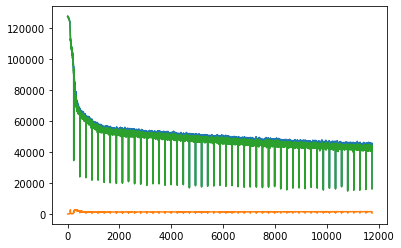

In [16]:
plt.plot(loss_log_list)
plt.plot(kl_log)
plt.plot(reconst_log)